# Pitch recognition from speech

In [1]:
import matplotlib.pyplot as plt
import rarfile
import subprocess
import random

from IPython.display import Audio
import librosa
import librosa.display
import librosa.feature as lf
import soundfile as sf
import speech_recognition as sr

import os
import glob
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple
from tqdm import tqdm

from scipy.stats import skew, kurtosis
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
%%time
# extract rar
rar_path = r"C:\Users\USER\Documents\...\Statements, Questions, and Exclamations.rar"
out_dir = r"C:\Users\USER\Documents\..."

subprocess.run([r"C:\Users\USER\Documents\...\UnRAR.exe", "x", "-y", rar_path, out_dir])


## Loading and Visualizing an Audio File

In [4]:
dataset_dir = r"C:\Users\USER\Documents\...\Statements, Questions, and Exclamations"

In [5]:
datatype = "Wave"
target = "Exclamations"
person = "1"
wav_path = os.path.join(dataset_dir, datatype , target, person, "1EF001.wav")
audio_signal, sample_rate = librosa.load(wav_path, sr=None)

In [6]:
sample_rate 

16000

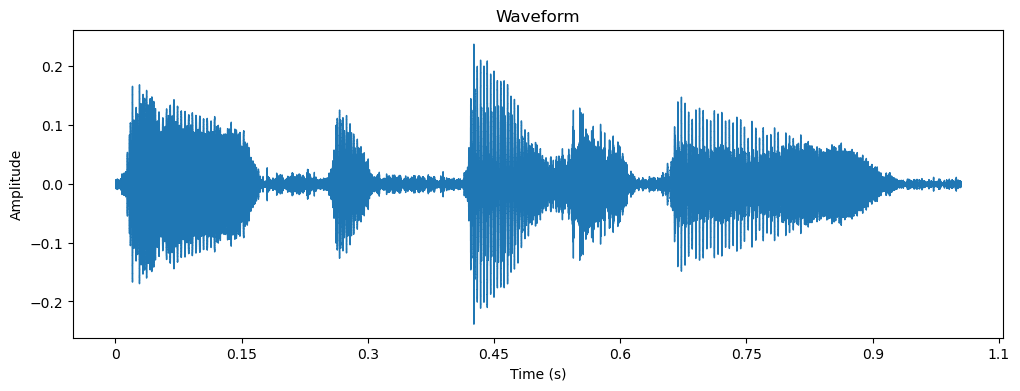

In [7]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio_signal, sr=sample_rate)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [8]:
# Play the audio in the notebook
Audio(wav_path)

**play audio of randomly selected file**

In [9]:
# QC
dataset_dir = r"C:\Users\USER\Documents\...\Statements, Questions, and Exclamations\Wave"
all_files = list(Path(dataset_dir).rglob("*.wav"))
print(len(all_files))  # raw count
# print(sorted(all_files)[:10])  # first 10 paths

12660


In [10]:
# play audio file
dataset_dir = r"C:\Users\USER\Documents\...\Statements, Questions, and Exclamations"
datatype = "Wave"
targets = ["Statements", "Questions", "Exclamations"]
target = random.choice(targets)
person = str(random.randint(1, 10)) 
person_dir = os.path.join(dataset_dir, datatype, target, person)

wav_files = [f for f in os.listdir(person_dir) if f.lower().endswith(".wav")]
wav_file = random.choice(wav_files)
print(target, wav_file)
wav_path = os.path.join(person_dir, wav_file)

audio_signal, sample_rate = librosa.load(wav_path, sr=None)
Audio(wav_path)

Exclamations 6EF101.wav


## Feature extraction

In [11]:
# ============ CONFIG ============
dataset_dir = r"C:\Users\USER\Documents\...\Statements, Questions, and Exclamations\Wave"
use_only_format = "wav"
sr = 16000
max_duration = 2.0
n_mfcc = 20
save_features_csv = "features_pitch_mfcc.csv"
random_state = 42
# ================================

In [12]:
np.random.seed(random_state)

In [13]:
def find_audio_files(root: str, use_ext: str):
    """
    Recursively find (filepath, label) pairs under root.
    Label = immediate subfolder name under root (e.g., 'Statements').
    """
    root = Path(root)
    files_labels = []
    for class_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        label = class_dir.name
        for f in class_dir.rglob(f"*.{use_ext.lower()}"):  # recursive search
            files_labels.append((str(f), label))
    return files_labels
    

In [14]:
def build_dataset(root: str, use_ext: str) -> pd.DataFrame:
    """
    Fully recursive feature builder with tqdm progress bar.
    Returns DataFrame with all features and labels.
    """
    items = find_audio_files(root, use_ext)
    print(f"Building df: found {len(items)} files under {root}")

    rows = []
    for fp, label in tqdm(items, desc="Extracting features", unit="file"):
        feats = file_to_features(fp)
        feats["label"] = label
        rows.append(feats)

    df = pd.DataFrame(rows)
    if "error" in df.columns:
        df = df[df["error"].isna() | (df["error"].astype(str) == "nan")]
        df = df.drop(columns=["error"], errors="ignore")
    return df


In [15]:
def robust_load_audio(path: str, sr: int = sr, duration: float = max_duration):
    """Load mono audio, resampled to sr, optionally trim duration."""
    y, sr = librosa.load(path, sr=sr, mono=True, duration=duration)
    y, _ = librosa.effects.trim(y, top_db=30)
    return y, sr

def summarize_vector(x: np.ndarray, prefix: str):
    x = x[np.isfinite(x)]
    if x.size == 0:
        return {f"{prefix}_{stat}": np.nan for stat in
                ["mean","std","min","max","p25","p50","p75","skew","kurt"]}
    return {
        f"{prefix}_mean": float(np.mean(x)),
        f"{prefix}_std": float(np.std(x)),
        f"{prefix}_min": float(np.min(x)),
        f"{prefix}_max": float(np.max(x)),
        f"{prefix}_p25": float(np.percentile(x, 25)),
        f"{prefix}_p50": float(np.percentile(x, 50)),
        f"{prefix}_p75": float(np.percentile(x, 75)),
        f"{prefix}_skew": float(skew(x)),
        f"{prefix}_kurt": float(kurtosis(x))
    }
    

In [16]:
def extract_features(y: np.ndarray, sr: int):
    feats = {}

    # --- Pitch (F0) ---
    f0, voiced_flag, voiced_prob = librosa.pyin(
        y, fmin=librosa.note_to_hz("C2"), fmax=librosa.note_to_hz("C7"), sr=sr
    )
    voiced_ratio = np.mean(np.isfinite(f0)) if f0 is not None else 0.0
    feats["voiced_ratio"] = float(voiced_ratio)
    if f0 is None: f0 = np.array([])

    feats.update(summarize_vector(f0[np.isfinite(f0)], "f0"))
    
    # Tail slope
    if f0.size > 10 and np.isfinite(f0).any():
        idx = np.where(np.isfinite(f0))[0]
        if idx.size > 5:
            end_cut = int(np.floor(idx.size * 0.2))
            tail_idx = idx[-end_cut:] if end_cut >= 3 else idx
            x = np.arange(len(tail_idx))
            y_tail = f0[tail_idx]
            feats["f0_tail_slope"] = float(np.polyfit(x, y_tail, 1)[0])
        else:
            feats["f0_tail_slope"] = np.nan
    else:
        feats["f0_tail_slope"] = np.nan

    # RMS, ZCR
    rms = lf.rms(y=y).squeeze()
    zcr = lf.zero_crossing_rate(y=y).squeeze()
    feats.update(summarize_vector(rms, "rms"))
    feats.update(summarize_vector(zcr, "zcr"))

    # Tempo
    try:
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        feats["tempo"] = float(tempo)
    except Exception:
        feats["tempo"] = np.nan

    # MFCC + deltas
    mfcc = lf.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    d1 = lf.delta(mfcc)
    d2 = lf.delta(mfcc, order=2)

    def agg_stats(mat, base):
        out = {}
        for i in range(mat.shape[0]):
            v = mat[i, :]
            out.update(summarize_vector(v, f"{base}{i+1}"))
        return out

    feats.update(agg_stats(mfcc, "mfcc"))
    feats.update(agg_stats(d1, "d1"))
    feats.update(agg_stats(d2, "d2"))

    # Spectral features
    centroid = lf.spectral_centroid(y=y, sr=sr).squeeze()
    bandwidth = lf.spectral_bandwidth(y=y, sr=sr).squeeze()
    rolloff = lf.spectral_rolloff(y=y, sr=sr, roll_percent=0.85).squeeze()
    flatness = lf.spectral_flatness(y=y).squeeze()
    feats.update(summarize_vector(centroid, "spec_cent"))
    feats.update(summarize_vector(bandwidth, "spec_bw"))
    feats.update(summarize_vector(rolloff, "spec_roll"))
    feats.update(summarize_vector(flatness, "spec_flat"))

    # Chroma
    chroma = lf.chroma_stft(y=y, sr=sr)
    for i in range(chroma.shape[0]):
        feats[f"chroma{i+1}_mean"] = float(np.mean(chroma[i]))
        feats[f"chroma{i+1}_std"] = float(np.std(chroma[i]))

    return feats

def file_to_features(path: str):
    try:
        y, sr_ = robust_load_audio(path, sr=sr, duration=max_duration)
        feats = extract_features(y, sr_)
        feats["duration_s"] = float(len(y)/sr_)
        feats["path"] = path
        return feats
    except Exception as e:
        return {"path": path, "error": str(e)}


## Model training

### Logistic Regression (baseline)

In [18]:
# === Train + evaluation ===
def train_and_eval_logreg(df: pd.DataFrame):
    '''
    Train Logistic Regression model as baseline
    '''
    print(f"Train and evaluate Logistic Regression (baseline) model")
    df = df.copy()
    
    # Prepare features & labels
    meta_cols = ["label", "path"]
    X = df.drop(columns=meta_cols, errors="ignore")
    X = X.loc[:, X.notna().any(axis=0)]
    X = X.fillna(X.median(numeric_only=True))
    y = df["label"].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    pipeline = Pipeline([
        ('var_thresh', VarianceThreshold(threshold=0.01)),  # drop near-constant features
        ('logreg', LogisticRegression(
            C=1.0, 
            solver='saga', 
            penalty='l2', 
            max_iter=500,
            n_jobs=-1,
            random_state=random_state
        ))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="accuracy")
    print(f"CV accuracy (mean ± std): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    # y_proba = pipeline.predict_proba(X_test)

    print(f"Holdout accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print("Classification report:\n", classification_report(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

    # Get selected features
    support_mask = pipeline.named_steps["var_thresh"].get_support()
    selected_features = np.array(X.columns)[support_mask]
    print(f"Trained on {len(selected_features)} feature columns (after variance threshold).")

    return pipeline, selected_features.tolist()


### SVM

In [19]:
# === Train + evaluation ===
def train_and_eval_svm(df: pd.DataFrame):
    '''
    Train SVM model
    '''
    print(f"Train and evaluate SVM model")
    df = df.copy()
    meta_cols = ["label", "path"]
    X = df.drop(columns=meta_cols, errors="ignore")
    X = X.loc[:, X.notna().any(axis=0)]
    X = X.fillna(X.median(numeric_only=True))
    y = df["label"].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    # Add VarianceThreshold before scaling
    pipe = Pipeline([
        ("var", VarianceThreshold(threshold=0.01)),  # remove low variance features
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", C=5, gamma="scale", 
                    probability=False, random_state=random_state))
    ])

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy")
    print(f"CV accuracy (mean ± std): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

    # Fit and evaluate on holdout
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f"Holdout accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print("Classification report:\n", classification_report(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

    # Get selected features
    support_mask = pipe.named_steps["var"].get_support()
    selected_features = np.array(X.columns)[support_mask]
    print(f"Trained on {len(selected_features)} feature columns (after variance threshold).")

    return pipe, selected_features.tolist()


In [20]:
# # === Train + evaluation ===
# def train_and_eval(df: pd.DataFrame):
#     print(f"Train and evaluate SVM model")
#     df = df.copy()
#     meta_cols = ["label", "path"]
#     X = df.drop(columns=meta_cols, errors="ignore")
#     X = X.loc[:, X.notna().any(axis=0)]
#     X = X.fillna(X.median(numeric_only=True))
#     y = df["label"].values

#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.2, stratify=y, random_state=random_state
#     )

#     # Define pipeline
#     pipe = Pipeline([
#         ("var", VarianceThreshold(threshold=0.01)),  # remove low variance features
#         ("scaler", StandardScaler()),
#         ("clf", SVC(probability=True, random_state=random_state))
#     ])

#     # Define parameter search space
#     search_spaces = {
#         "clf__C": Real(1e-2, 1e2, prior="log-uniform"),
#         "clf__gamma": Real(1e-4, 1e0, prior="log-uniform"),
#         "clf__kernel": Categorical(["rbf", "poly", "sigmoid"])
#     }

#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

#     opt = BayesSearchCV(
#         estimator=pipe,
#         search_spaces=search_spaces,
#         n_iter=10, 
#         cv=cv,
#         scoring="accuracy",
#         n_jobs=-1,
#         random_state=random_state,
#         verbose=1
#     )

#     opt.fit(X_train, y_train)

#     print(f"Best params: {opt.best_params_}")
#     print(f"CV accuracy: {opt.best_score_:.3f}")

#     # Evaluate on holdout
#     y_pred = opt.predict(X_test)
#     print(f"Holdout accuracy: {accuracy_score(y_test, y_pred):.3f}")
#     print("Classification report:\n", classification_report(y_test, y_pred))
#     print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

#     # Get selected feature names
#     support_mask = opt.best_estimator_.named_steps["var"].get_support()
#     selected_features = np.array(X.columns)[support_mask]

#     return opt, selected_features.tolist()


In [21]:
%%time
def main():
    if not os.path.exists(save_features_csv):
        # Build features only once
        print(f"Scanning: {dataset_dir} (format: .{use_only_format})")
        df = build_dataset(dataset_dir, use_only_format)
        if df.empty:
            raise RuntimeError("No audio files found. Check dataset dir and format.")

        # Summary per class
        counts = df['label'].value_counts()
        print(f"Found {len(df)} files across {df['label'].nunique()} classes:")
        for label, cnt in counts.items():
            print(f"  {label}: {cnt}")

        df.to_csv(save_features_csv, index=False)
        print(f"Saved features to: {os.path.abspath(save_features_csv)}")
    else:
        print(f"Loading saved features: {save_features_csv}")
        df = pd.read_csv(save_features_csv)

    # baseline model
    logreg_model, feat_cols = train_and_eval_logreg(df)
    print(f"Trained on {len(feat_cols)} feature columns using LogReg model.")
    
    # Train using features
    svm_model, feat_cols = train_and_eval_svm(df)
    print(f"Trained on {len(feat_cols)} feature columns using SVM model.")

if __name__ == "__main__":
    main()


Loading saved features: features_pitch_mfcc.csv
Train and evaluate Logistic Regression (baseline) model


C:\Users\USER\anaconda3\envs\speech_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\envs\speech_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\envs\speech_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\envs\speech_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\envs\speech_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


CV accuracy (mean ± std): 0.605 ± 0.004


C:\Users\USER\anaconda3\envs\speech_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Holdout accuracy: 0.614
Classification report:
               precision    recall  f1-score   support

Exclamations       0.62      0.58      0.60       840
   Questions       0.66      0.65      0.66       845
  Statements       0.57      0.61      0.59       847

    accuracy                           0.61      2532
   macro avg       0.62      0.61      0.61      2532
weighted avg       0.62      0.61      0.61      2532

Confusion matrix:
 [[487 134 219]
 [118 553 174]
 [186 147 514]]
Trained on 599 feature columns (after variance threshold).
Trained on 599 feature columns using LogReg model.
Train and evaluate SVM model
CV accuracy (mean ± std): 0.734 ± 0.010
Holdout accuracy: 0.739
Classification report:
               precision    recall  f1-score   support

Exclamations       0.72      0.72      0.72       840
   Questions       0.79      0.77      0.78       845
  Statements       0.71      0.73      0.72       847

    accuracy                           0.74      2532
   macr